In [1]:
#!pip install ndlib
#!pip install --upgrade decorator

In [59]:
import networkx as nx
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

###########
# import our libraries
from blue_conduit_spatial.utilities import build_datasets, load_datasets
from blue_conduit_spatial.evaluation import *

########### set random state
np.random.seed(297)

In [45]:
Xtrain, Xtest, Ytrain, Ytest = build_datasets('../data/flint_sl_materials')

In [50]:
Xtrain

,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Commercial Building Value,Parcel Acres,Year Built,Latitude,Longitude,...,CENTRACT_3800,CENTRACT_4000,CENTRACT_13500,CENTRACT_13600,CENBLOCK_1,CENBLOCK_2,CENBLOCK_3,CENBLOCK_4,CENBLOCK_5,CENBLOCK_6
1,100.0,11800,420,0,23227,0.0,0.050,2,43.017650,-83.697217,...,0,0,0,0,0,1,0,0,0,0
3,50.0,4550,781,0,17452,0.0,0.086,2,43.017543,-83.698229,...,0,0,0,0,0,1,0,0,0,0
4,100.0,12800,510,0,25104,0.0,0.070,1900,43.013583,-83.695357,...,0,0,0,0,0,1,0,0,0,0
5,100.0,0,598,0,19131,0.0,0.071,2,43.018324,-83.697418,...,0,0,0,0,0,1,0,0,0,0
16,0.0,0,2012,0,32721,0.0,0.100,1898,43.014492,-83.684542,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26619,100.0,5400,668,0,41987,0.0,0.200,1964,43.069477,-83.705938,...,0,0,0,0,0,0,0,1,0,0
26620,100.0,6300,1002,0,59266,0.0,0.300,1929,43.069370,-83.705601,...,0,0,0,0,0,0,0,1,0,0
26621,100.0,6100,752,0,54398,0.0,0.225,1960,43.068821,-83.705519,...,0,0,0,0,0,0,0,1,0,0
26622,0.0,0,653,0,26643,0.0,0.191,1953,43.070891,-83.705361,...,0,0,0,0,0,0,0,1,0,0


In [58]:
Ytest.index.values

array([    0,     2,     6, ..., 26860, 26861, 26862])

In [57]:
load_dir = '../data/test_dir'
#Xtrain, Xtest, Ytrain, Ytest = load_datasets(load_dir)

jared_train_pred = pd.read_csv(f'{load_dir}/predictions/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv(f'{load_dir}/predictions/jared_test_yhat.csv').values

dis_path = '../data/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)
dis_data = distances['road_distances']
dis_key_map = distances['idx2pid'].item()
dis_key_map_inv = dict(zip(dis_key_map.values(), dis_key_map.keys()))
print('finished building key map and inverse')
#print(dis_key_map)
def knn_datasets(Y, Yhat, key_map_inv, dis_data, K=5):
    # Keep only entries with calculated distances
    
    # old version
    #filter_ = np.array([pid in key_map_inv for pid in Y.pid.values])
    # new version
    filter_ = np.array([dis_key_map[idx] in key_map_inv for idx in Y.index.values])
    Y_filter = Y.iloc[filter_]
    Yhat_filter = Yhat[:,1][filter_]
    
    # Get dataset distances
    # old version
    #pid = Y_filter.pid.values
    # new version
    pid = [dis_key_map[idx] for idx in Y_filter.index.values]
    dis_idx = [dis_key_map_inv[pid_] for pid_ in pid]
    dis_data = dis_data[dis_idx, :][:,dis_idx]
    
    # Get sorted K-th minimum distances index
    dis_min_idx = np.argpartition(dis_data, K, axis=1)[:,:K]
    dis_min_resort = np.argsort(np.take_along_axis(dis_data, dis_min_idx, axis=1), axis=1)
    dis_min_idx = np.take_along_axis(dis_min_idx, dis_min_resort, axis=1)
    
    # Get probabilities of K neighbours
    N = Y_filter.shape[0]
    Yhat_rep = np.repeat(Yhat_filter.reshape(1,-1), N, axis=0)
    knn_data = np.take_along_axis(Yhat_rep, dis_min_idx, axis=1)
    
    return Y_filter, Yhat_filter, knn_data

Ytrain_knn_5, jared_train_knn_5, knn_data_train_5 = knn_datasets(Ytrain, jared_train_pred, dis_key_map_inv, dis_data, K=5)
Ytest_knn_5, jared_test_knn_5, knn_data_test_5 = knn_datasets(Ytest, jared_test_pred, dis_key_map_inv, dis_data, K=5)

finished building key map and inverse


KeyError: 26857

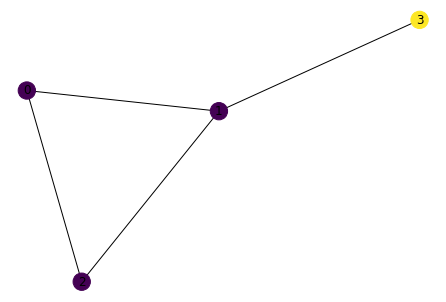

In [66]:
# from dictionary
d = {0 : {1 : 1}, 1 : {3 : 1}, 2 : {0 : 1, 1 : 1}}
g = nx.Graph(d)
nx.draw(g, node_color=[.1,.2,.3,450], with_labels=True)
plt.show()